In [1]:
# import necessary packages
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL
import imageio
import random
# import SimpleITK as sitk
from IPython import display
from IPython.display import Image


## Source Git

https://github.com/apolanco3225/Data-Augmentation-and-Segmentation-with-GANs-for-Medical-Images/blob/master/startGANs.ipynb

mit Verwendung (wahrscheinlich original Repo) von
- https://gist.github.com/mahmoodm2/519099b45e31f1bce159a6a13e44e1d0

## Data Exploration

In [2]:
def getAllImages(path):

    files = []

    for folder in os.listdir(path):

        if "." not in folder: 

            for image in os.listdir(path + folder):

                img = path + folder + "/" + image

                files.append(img)

    return files

In [3]:
benign_path = 'D:/Medical_Imaging_Projekt/Dataset/benign/'
malignant_path = 'D:/Medical_Imaging_Projekt/Dataset/malignant/'

In [4]:
files_benign = getAllImages(benign_path)
print("Sample size of benign images:", len(files_benign))


files_malignant = getAllImages(malignant_path)
print("Sample size of malignant images:", len(files_malignant))

Sample size of benign images: 625
Sample size of malignant images: 1370


In [5]:
def showSamples(files, name):

    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    for ax in axes:

        idx = np.random.randint(0, len(files))
        
        filename = files[idx]

        img = mpimg.imread(filename)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Breast Cancer Histopathological {} Image with size: {}'.format(name, img.shape))

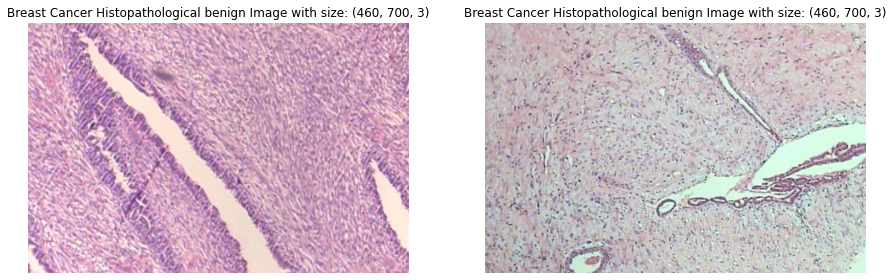

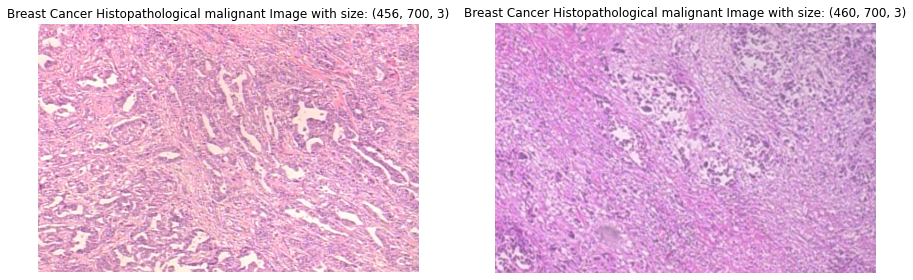

In [6]:
showSamples(files_benign, 'benign')
showSamples(files_malignant, 'malignant')

## Data Processing

In [7]:
# files = [*files_benign, *files_malignant]
files = [*files_benign]
print(len(files))

625


In [8]:
# read images and provide a consitent size of 64 by 64 pixels
def reformatSizeImage(filename):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels = 1)
    image_resized = tf.image.resize(image_decoded, [256, 256])

    return image_resized

In [9]:
# normalize images
def normalizeImages(image):

    image = (image - 127.5) / 127.5
    
    return image

In [10]:
random.shuffle(files)

dataset = tf.data.Dataset.from_tensor_slices((files))

dataset = dataset.shuffle(10000)

dataset = dataset.map(reformatSizeImage, num_parallel_calls = 16)

dataset = dataset.map(normalizeImages, num_parallel_calls = 16)

In [11]:
dataset = dataset.batch(256).prefetch(256 * 4)

## GAN Architecture

### Generator

In [12]:
# create generator class
class Generator(tf.keras.Model):

    def __init__(self):

        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(8*8*256, use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        self.conv1 = tf.keras.layers.Conv2DTranspose(256 * 8, (4, 4), strides=(1, 1), padding='same', use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2DTranspose(256 * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2DTranspose(256 * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()

        self.conv4 = tf.keras.layers.Conv2DTranspose(256 * 1, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm5 = tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', use_bias=False)

    def call(self, x, training=True):

        x = self.fc1(x)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.relu(x)

        x = tf.reshape(x, shape=(-1, 8, 8, 256))

        x = self.conv1(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv4(x)
        x = self.batchnorm5(x, training=training)
        x = tf.nn.relu(x)

        x = tf.nn.tanh(self.conv5(x))  
        
        return x

### Discriminator

In [13]:
# create discriminator class
class Discriminator(tf.keras.Model):

    def __init__(self):
        
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(256 * 2, (4, 4), strides=(2, 2), padding='same')
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(256 * 4, (4, 4), strides=(2, 2), padding='same')
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2D(256 * 8, (4, 4), strides=(2, 2), padding='same')
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.conv5 = tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid')

        self.dropout = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):

        x = tf.nn.leaky_relu(self.conv1(x))

        x = self.conv2(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv3(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv4(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv5(x)
        x = self.fc1(x)

        return x

In [14]:
generator = Generator()
discriminator = Discriminator()

In [15]:
# generator.call = tf.contrib.eager.defun(generator.call)
# discriminator.call = tf.contrib.eager.defun(discriminator.call)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# loss function discriminator  
def discriminator_loss(real_output, generated_output):

    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # [0,0,...,0] with generated images since they are fake
    generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
    total_loss = real_loss + generated_loss
    
    return total_loss

# loss function discriminator generator
def generator_loss(generated_output):

    return cross_entropy(tf.ones_like(generated_output), generated_output)

In [17]:
def generate_and_save_images(model, epoch, test_input, imsave_dir):

    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()
    plt.savefig(os.path.join(imsave_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

#### Hyperparameters

In [18]:
BATCH_SIZE = 1
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

In [19]:
checkpoint_dir = './GAN_Images/training_checkpoints/'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
save_dir_benign = "./GAN_Images/benign/"
save_dir_malignant = "./GAN_Images/malignant/"

save_dir = save_dir_benign

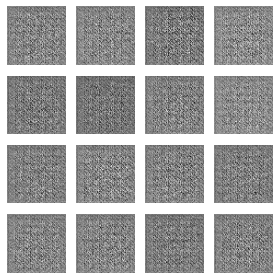

Time taken for epoch 2 is 474.81633949279785 sec


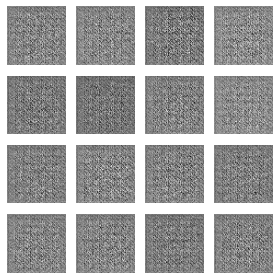

In [21]:
#tfe = tf.contrib.eager
random_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim])


for epoch in range(EPOCHS):

    start = time.time()
    
    for images in dataset:

        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator(noise, training=True)
            
            real_output = discriminator(images, training=True)
            generated_output = discriminator(generated_images, training=True)
            
            gen_loss = generator_loss(generated_output)
            disc_loss = discriminator_loss(real_output, generated_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      
    display.clear_output(wait = True)

    generate_and_save_images(generator, epoch + 1, random_vector_for_generation, save_dir)

    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0: #das auf 15 ändern
        
        # checkpoint.save(file_prefix = checkpoint_prefix)
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

# generating after the final epoch
# display.clear_output(wait = True)
generate_and_save_images(generator, epoch, random_vector_for_generation, save_dir)